# **Deep Learning Course**

## **Loss Functions and Multilayer Perceptrons (MLP)**

---

### **Student Information:**

- **Name:** *Seyed Mohammad Ojagh Kazzazi*
- **Student Number:** *400100554*

---

### **Assignment Overview**

In this notebook, we will explore various loss functions used in neural networks, with a specific focus on their role in training **Multilayer Perceptrons (MLPs)**. By the end of this notebook, you will have a deeper understanding of:
- Types of loss functions
- How loss functions affect the training process
- The relationship between loss functions and model optimization in MLPs

---

### **Table of Contents**

1. Introduction to Loss Functions
2. Types of Loss Functions
3. Multilayer Perceptrons (MLP)
4. Implementing Loss Functions in MLP
5. Conclusion

---



# 1.Introduction to Loss Functions 

In deep learning, **loss functions** play a crucial role in training models by quantifying the difference between the predicted outputs and the actual targets. Selecting the appropriate loss function is essential for the success of your model. In this assay, we will explore various loss functions available in PyTorch, understand their theoretical backgrounds, and provide you with a scaffolded class to experiment with these loss functions.

Before begining, let's train a simle MLP model using the **L1Loss** function. We'll return to this model later to experiment with different loss functions. We'll start by importing the necessary libraries and defining the model architecture.

First things first, let's talk about **L1Loss**.

### 1. L1Loss (`torch.nn.L1Loss`)
- **Description:** Also known as Mean Absolute Error (MAE), L1Loss computes the average absolute difference between the predicted values and the target values.
- **Use Case:** Suitable for regression tasks where robustness to outliers is desired.

Here is the mathematical formulation of L1Loss:
\begin{equation}
\text{L1Loss} = \frac{1}{n} \sum_{i=1}^{n} |y_{\text{pred}_i} - y_{\text{true}_i}|
\end{equation}

Let's implement a simple MLP model using the L1Loss function.

In [88]:
import torch
import torch.nn as nn
import torch.optim as optim
import pandas as pd
from torch.utils.data import TensorDataset, DataLoader
from sklearn.model_selection import train_test_split
from torch.optim import Adam
# Don't be courious about Adam, it's just a fancy name for a fancy optimization algorithm

Here, we'll define a class called `SimpleMLP` that inherits from `nn.Module`. This class can have multiple layers, and we'll use the `nn.Sequential` module to define the layers of the model. The model will have the following architecture:

In [89]:
import torch.nn as nn
class SimpleMLP(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim, num_hidden_layers=1, last_layer_activation_fn=nn.ReLU):
        super(SimpleMLP, self).__init__()

        # Define the layers of the MLP
        layers = []
        layers.append(nn.Linear(input_dim, hidden_dim))  # Input layer to first hidden layer
        
        # Add hidden layers
        for _ in range(num_hidden_layers - 1):
            layers.append(nn.ReLU())  # Activation function between hidden layers
            layers.append(nn.Linear(hidden_dim, hidden_dim))  # Hidden layer
        
        # Last hidden layer to output layer
        layers.append(last_layer_activation_fn())  # Activation function for last layer if specified
        layers.append(nn.Linear(hidden_dim, output_dim))  # Output layer

        # Combine all layers into a sequential model
        self.network = nn.Sequential(*layers)

    def forward(self, x):
        # Define the forward pass of the MLP
        return self.network(x)

Now, let's define a class called `SimpleMLP_Loss` that has the following architecture:

In [90]:
from tqdm import tqdm

class SimpleMLPTrainer:  #this is for the Binary Classification
    def __init__(self, model, criterion, optimizer):
        self.model = model
        self.criterion = criterion
        self.optimizer = optimizer

    def train(self, train_loader, num_epochs):
        self.model.train()  # Set the model to training mode
        train_losses = []

        for epoch in range(num_epochs):
            running_loss = 0.0
            with tqdm(train_loader, desc=f'Epoch {epoch+1}/{num_epochs}', unit='batch') as pbar:
                for inputs, targets in pbar:
                    # Zero the gradients
                    self.optimizer.zero_grad()

                    # Forward pass
                    outputs = self.model(inputs)

                    # Compute the loss
                    loss = self.criterion(outputs, targets.unsqueeze(1).float())  # Convert targets to float32 for BCEWithLogitsLoss
                    running_loss += loss.item()

                    # Backward pass and optimization
                    loss.backward()
                    self.optimizer.step()

                    # Update progress bar
                    pbar.set_postfix(loss=running_loss / (pbar.n + 1))

            avg_loss = running_loss / len(train_loader)
            train_losses.append(avg_loss)
            print(f"Epoch {epoch+1}/{num_epochs}, Training Loss: {avg_loss:.4f}")

        return train_losses

    def evaluate(self, val_loader):
        self.model.eval()  # Set the model to evaluation mode
        val_loss = 0.0
        correct = 0
        total = 0

        with torch.no_grad():  # No gradients are needed for validation
            for inputs, targets in val_loader:
                # Forward pass
                outputs = self.model(inputs)

                # Compute the loss
                loss = self.criterion(outputs, targets.unsqueeze(1).float())
                val_loss += loss.item()

                # For binary classification, you can compute accuracy
                predicted = (outputs > 0.5).float()  # Binary classification (threshold at 0.5)
                total += targets.size(0)
                correct += (predicted.squeeze() == targets).sum().item()

        avg_val_loss = val_loss / len(val_loader)
        accuracy = correct / total * 100
        print(f"Validation Loss: {avg_val_loss:.4f}, Accuracy: {accuracy:.2f}%")

        return avg_val_loss, accuracy

Next, lets test our model using the L1Loss function. You'll use <span style="color:red">*Titanic Dataset*</span> to train the model.


In [91]:
import torch
import torch.nn as nn
import torch.optim as optim
import pandas as pd
from sklearn.model_selection import train_test_split
from torch.utils.data import DataLoader, TensorDataset

# Load dataset
train_url = "https://raw.githubusercontent.com/datasciencedojo/datasets/master/titanic.csv"
data = pd.read_csv(train_url)

# Preprocessing (simple example)
data = data[['Pclass', 'Sex', 'Age', 'Fare', 'Survived']].dropna()
data['Sex'] = data['Sex'].map({'male': 0, 'female': 1})

# Features and targets
X = data[['Pclass', 'Sex', 'Age', 'Fare']].values  # Features
y = data['Survived'].values  # Target (already binary, but will use it for multi-class classification)

# Convert the data to PyTorch tensors
X_tensor = torch.tensor(X, dtype=torch.float32)
y_tensor = torch.tensor(y, dtype=torch.long)  # Use long for multi-class labels

# Create a TensorDataset and DataLoader for batching
dataset = TensorDataset(X_tensor, y_tensor)

# Split the data into training and validation sets (80-20 split)
train_data, val_data = train_test_split(dataset, test_size=0.2, random_state=42)

# Create DataLoader for training and validation sets
train_loader = DataLoader(train_data, batch_size=32, shuffle=True)
val_loader = DataLoader(val_data, batch_size=32, shuffle=False)



<div style="text-align: center;"> <span style="color:red; font-size: 26px; font-weight: bold;">Let's train!</span> </div>

In [92]:
from torch.nn import L1Loss


# Loss function for multi-class classification (with LogSoftmax)
criterion = L1Loss()

# Define the model, criterion, and optimizer
input_dim = X_tensor.shape[1]  # Number of input features (4 in this case)
hidden_dim = 32  # Number of hidden units
output_dim = 1  # For binary classification (Survived: 0 or 1)


# Instantiate the model
model = SimpleMLP(input_dim, hidden_dim, output_dim)

# Optimizer (Adam)
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Print model summary (optional)
print(model)

# Now use the SimpleMLPTrainer class
trainer = SimpleMLPTrainer(model, criterion, optimizer)

# Train the model
num_epochs = 50
train_losses = trainer.train(train_loader, num_epochs)

# Evaluate the model
val_loss, accuracy = trainer.evaluate(val_loader)
print(f"Final Validation Loss: {val_loss:.4f}, Accuracy: {accuracy:.2f}%")

SimpleMLP(
  (network): Sequential(
    (0): Linear(in_features=4, out_features=32, bias=True)
    (1): ReLU()
    (2): Linear(in_features=32, out_features=1, bias=True)
  )
)


Epoch 1/50: 100%|██████████| 18/18 [00:00<00:00, 550.98batch/s, loss=28.1]


Epoch 1/50, Training Loss: 1.5635


Epoch 2/50: 100%|██████████| 18/18 [00:00<00:00, 602.43batch/s, loss=9.75]


Epoch 2/50, Training Loss: 0.5418


Epoch 3/50: 100%|██████████| 18/18 [00:00<00:00, 611.92batch/s, loss=7.7]


Epoch 3/50, Training Loss: 0.4275


Epoch 4/50: 100%|██████████| 18/18 [00:00<00:00, 637.85batch/s, loss=7.51]


Epoch 4/50, Training Loss: 0.4169


Epoch 5/50: 100%|██████████| 18/18 [00:00<00:00, 556.78batch/s, loss=7.45]


Epoch 5/50, Training Loss: 0.4140


Epoch 6/50: 100%|██████████| 18/18 [00:00<00:00, 622.83batch/s, loss=7.01]


Epoch 6/50, Training Loss: 0.3897


Epoch 7/50: 100%|██████████| 18/18 [00:00<00:00, 602.19batch/s, loss=6.93]


Epoch 7/50, Training Loss: 0.3849


Epoch 8/50: 100%|██████████| 18/18 [00:00<00:00, 609.98batch/s, loss=6.63]


Epoch 8/50, Training Loss: 0.3685


Epoch 9/50: 100%|██████████| 18/18 [00:00<00:00, 611.02batch/s, loss=6.79]


Epoch 9/50, Training Loss: 0.3771


Epoch 10/50: 100%|██████████| 18/18 [00:00<00:00, 638.97batch/s, loss=6.63]


Epoch 10/50, Training Loss: 0.3682


Epoch 11/50: 100%|██████████| 18/18 [00:00<00:00, 597.67batch/s, loss=6.39]


Epoch 11/50, Training Loss: 0.3549


Epoch 12/50: 100%|██████████| 18/18 [00:00<00:00, 647.74batch/s, loss=6.41]


Epoch 12/50, Training Loss: 0.3562


Epoch 13/50: 100%|██████████| 18/18 [00:00<00:00, 599.62batch/s, loss=6.16]


Epoch 13/50, Training Loss: 0.3420


Epoch 14/50: 100%|██████████| 18/18 [00:00<00:00, 615.72batch/s, loss=6.18]


Epoch 14/50, Training Loss: 0.3433


Epoch 15/50: 100%|██████████| 18/18 [00:00<00:00, 569.59batch/s, loss=6.3]


Epoch 15/50, Training Loss: 0.3500


Epoch 16/50: 100%|██████████| 18/18 [00:00<00:00, 558.63batch/s, loss=6.07]


Epoch 16/50, Training Loss: 0.3372


Epoch 17/50: 100%|██████████| 18/18 [00:00<00:00, 570.92batch/s, loss=6.06]


Epoch 17/50, Training Loss: 0.3369


Epoch 18/50: 100%|██████████| 18/18 [00:00<00:00, 591.21batch/s, loss=5.89]


Epoch 18/50, Training Loss: 0.3270


Epoch 19/50: 100%|██████████| 18/18 [00:00<00:00, 546.38batch/s, loss=5.81]


Epoch 19/50, Training Loss: 0.3229


Epoch 20/50: 100%|██████████| 18/18 [00:00<00:00, 625.89batch/s, loss=5.9]


Epoch 20/50, Training Loss: 0.3276


Epoch 21/50: 100%|██████████| 18/18 [00:00<00:00, 613.15batch/s, loss=6.05]


Epoch 21/50, Training Loss: 0.3359


Epoch 22/50: 100%|██████████| 18/18 [00:00<00:00, 284.24batch/s, loss=5.91]


Epoch 22/50, Training Loss: 0.3283


Epoch 23/50: 100%|██████████| 18/18 [00:00<00:00, 451.95batch/s, loss=5.73]


Epoch 23/50, Training Loss: 0.3183


Epoch 24/50: 100%|██████████| 18/18 [00:00<00:00, 596.68batch/s, loss=5.73]


Epoch 24/50, Training Loss: 0.3185


Epoch 25/50: 100%|██████████| 18/18 [00:00<00:00, 650.97batch/s, loss=5.84]


Epoch 25/50, Training Loss: 0.3243


Epoch 26/50: 100%|██████████| 18/18 [00:00<00:00, 606.71batch/s, loss=6.05]


Epoch 26/50, Training Loss: 0.3359


Epoch 27/50: 100%|██████████| 18/18 [00:00<00:00, 578.64batch/s, loss=5.73]


Epoch 27/50, Training Loss: 0.3182


Epoch 28/50: 100%|██████████| 18/18 [00:00<00:00, 621.74batch/s, loss=5.43]


Epoch 28/50, Training Loss: 0.3019


Epoch 29/50: 100%|██████████| 18/18 [00:00<00:00, 582.30batch/s, loss=5.66]


Epoch 29/50, Training Loss: 0.3142


Epoch 30/50: 100%|██████████| 18/18 [00:00<00:00, 568.59batch/s, loss=6.04]


Epoch 30/50, Training Loss: 0.3356


Epoch 31/50: 100%|██████████| 18/18 [00:00<00:00, 567.19batch/s, loss=6.02]


Epoch 31/50, Training Loss: 0.3344


Epoch 32/50: 100%|██████████| 18/18 [00:00<00:00, 630.03batch/s, loss=5.28]


Epoch 32/50, Training Loss: 0.2933


Epoch 33/50: 100%|██████████| 18/18 [00:00<00:00, 619.28batch/s, loss=5.42]


Epoch 33/50, Training Loss: 0.3013


Epoch 34/50: 100%|██████████| 18/18 [00:00<00:00, 639.55batch/s, loss=5.43]


Epoch 34/50, Training Loss: 0.3016


Epoch 35/50: 100%|██████████| 18/18 [00:00<00:00, 551.91batch/s, loss=5.16]


Epoch 35/50, Training Loss: 0.2869


Epoch 36/50: 100%|██████████| 18/18 [00:00<00:00, 644.81batch/s, loss=5.32]


Epoch 36/50, Training Loss: 0.2954


Epoch 37/50: 100%|██████████| 18/18 [00:00<00:00, 632.45batch/s, loss=5.19]


Epoch 37/50, Training Loss: 0.2886


Epoch 38/50: 100%|██████████| 18/18 [00:00<00:00, 622.04batch/s, loss=5.15]


Epoch 38/50, Training Loss: 0.2862


Epoch 39/50: 100%|██████████| 18/18 [00:00<00:00, 615.24batch/s, loss=4.99]


Epoch 39/50, Training Loss: 0.2773


Epoch 40/50: 100%|██████████| 18/18 [00:00<00:00, 608.54batch/s, loss=5.09]


Epoch 40/50, Training Loss: 0.2827


Epoch 41/50: 100%|██████████| 18/18 [00:00<00:00, 618.66batch/s, loss=5.06]


Epoch 41/50, Training Loss: 0.2811


Epoch 42/50: 100%|██████████| 18/18 [00:00<00:00, 628.45batch/s, loss=5]


Epoch 42/50, Training Loss: 0.2778


Epoch 43/50: 100%|██████████| 18/18 [00:00<00:00, 587.18batch/s, loss=5.14]


Epoch 43/50, Training Loss: 0.2858


Epoch 44/50: 100%|██████████| 18/18 [00:00<00:00, 654.19batch/s, loss=5.21]


Epoch 44/50, Training Loss: 0.2894


Epoch 45/50: 100%|██████████| 18/18 [00:00<00:00, 633.58batch/s, loss=4.91]


Epoch 45/50, Training Loss: 0.2727


Epoch 46/50: 100%|██████████| 18/18 [00:00<00:00, 534.16batch/s, loss=4.78]


Epoch 46/50, Training Loss: 0.2654


Epoch 47/50: 100%|██████████| 18/18 [00:00<00:00, 597.32batch/s, loss=5.04]


Epoch 47/50, Training Loss: 0.2801


Epoch 48/50: 100%|██████████| 18/18 [00:00<00:00, 537.26batch/s, loss=5.01]


Epoch 48/50, Training Loss: 0.2781


Epoch 49/50: 100%|██████████| 18/18 [00:00<00:00, 638.43batch/s, loss=4.68]


Epoch 49/50, Training Loss: 0.2598


Epoch 50/50: 100%|██████████| 18/18 [00:00<00:00, 670.24batch/s, loss=4.94]


Epoch 50/50, Training Loss: 0.2744
Validation Loss: 0.3055, Accuracy: 73.43%
Final Validation Loss: 0.3055, Accuracy: 73.43%


---
# 2. Types of Loss Functions

PyTorch offers a variety of built-in loss functions tailored for different types of problems, such as regression, classification, and more. Below, we discuss several commonly used loss functions, their theoretical foundations, and typical use cases.

### 2. MSELoss (`torch.nn.MSELoss`)
- **Description:** Mean Squared Error (MSE) calculates the average of the squares of the differences between predicted and target values.
- **Use Case:** Commonly used in regression problems where larger errors are significantly penalized.

Here is boring math stuff for MSE:
\begin{equation}
\text{MSE} = \frac{1}{n} \sum_{i=1}^{n} (y_{i} - \hat{y}_{i})^{2}
\end{equation}

<span style="color:red; font-size: 18px; font-weight: bold;">Warning:</span> Don't forget to reinitialize the model before experimenting with different loss functions.

In [93]:
from torch.nn import MSELoss

criterion = MSELoss()

# Define the model, criterion, and optimizer
input_dim = X_tensor.shape[1]  # Number of input features (4 in this case)
hidden_dim = 32  # Number of hidden units
output_dim = 1  # For binary classification (Survived: 0 or 1)

# Instantiate the model
model = SimpleMLP(input_dim, hidden_dim, output_dim)

# Optimizer (Adam)
optimizer = optim.Adam(model.parameters(), lr=0.001)



# Now use the SimpleMLPTrainer class
trainer = SimpleMLPTrainer(model, criterion, optimizer)

# Train the model
num_epochs = 50
train_losses = trainer.train(train_loader, num_epochs)

# Evaluate the model
val_loss, accuracy = trainer.evaluate(val_loader)
print(f"Final Validation Loss: {val_loss:.4f}, Accuracy: {accuracy:.2f}%")

Epoch 1/50: 100%|██████████| 18/18 [00:00<00:00, 592.75batch/s, loss=560]


Epoch 1/50, Training Loss: 31.1185


Epoch 2/50: 100%|██████████| 18/18 [00:00<00:00, 588.75batch/s, loss=216]


Epoch 2/50, Training Loss: 11.9978


Epoch 3/50: 100%|██████████| 18/18 [00:00<00:00, 663.52batch/s, loss=66.1]


Epoch 3/50, Training Loss: 3.6730


Epoch 4/50: 100%|██████████| 18/18 [00:00<00:00, 622.64batch/s, loss=27.8]


Epoch 4/50, Training Loss: 1.5424


Epoch 5/50: 100%|██████████| 18/18 [00:00<00:00, 618.43batch/s, loss=10.5]


Epoch 5/50, Training Loss: 0.5843


Epoch 6/50: 100%|██████████| 18/18 [00:00<00:00, 627.55batch/s, loss=8.53]


Epoch 6/50, Training Loss: 0.4741


Epoch 7/50: 100%|██████████| 18/18 [00:00<00:00, 600.92batch/s, loss=7.6]


Epoch 7/50, Training Loss: 0.4223


Epoch 8/50: 100%|██████████| 18/18 [00:00<00:00, 569.19batch/s, loss=6.78]


Epoch 8/50, Training Loss: 0.3768


Epoch 9/50: 100%|██████████| 18/18 [00:00<00:00, 620.99batch/s, loss=6.26]


Epoch 9/50, Training Loss: 0.3478


Epoch 10/50: 100%|██████████| 18/18 [00:00<00:00, 551.81batch/s, loss=5.8]


Epoch 10/50, Training Loss: 0.3224


Epoch 11/50: 100%|██████████| 18/18 [00:00<00:00, 583.83batch/s, loss=5.5]


Epoch 11/50, Training Loss: 0.3057


Epoch 12/50: 100%|██████████| 18/18 [00:00<00:00, 595.61batch/s, loss=5.12]


Epoch 12/50, Training Loss: 0.2845


Epoch 13/50: 100%|██████████| 18/18 [00:00<00:00, 621.11batch/s, loss=4.85]


Epoch 13/50, Training Loss: 0.2693


Epoch 14/50: 100%|██████████| 18/18 [00:00<00:00, 654.33batch/s, loss=4.66]


Epoch 14/50, Training Loss: 0.2591


Epoch 15/50: 100%|██████████| 18/18 [00:00<00:00, 646.64batch/s, loss=4.46]


Epoch 15/50, Training Loss: 0.2480


Epoch 16/50: 100%|██████████| 18/18 [00:00<00:00, 613.16batch/s, loss=4.3]


Epoch 16/50, Training Loss: 0.2388


Epoch 17/50: 100%|██████████| 18/18 [00:00<00:00, 638.82batch/s, loss=4.2]


Epoch 17/50, Training Loss: 0.2333


Epoch 18/50: 100%|██████████| 18/18 [00:00<00:00, 577.18batch/s, loss=4.07]


Epoch 18/50, Training Loss: 0.2262


Epoch 19/50: 100%|██████████| 18/18 [00:00<00:00, 652.84batch/s, loss=3.98]


Epoch 19/50, Training Loss: 0.2210


Epoch 20/50: 100%|██████████| 18/18 [00:00<00:00, 579.56batch/s, loss=3.91]


Epoch 20/50, Training Loss: 0.2174


Epoch 21/50: 100%|██████████| 18/18 [00:00<00:00, 616.50batch/s, loss=3.93]


Epoch 21/50, Training Loss: 0.2185


Epoch 22/50: 100%|██████████| 18/18 [00:00<00:00, 262.91batch/s, loss=3.8]


Epoch 22/50, Training Loss: 0.2111


Epoch 23/50: 100%|██████████| 18/18 [00:00<00:00, 603.87batch/s, loss=3.7]


Epoch 23/50, Training Loss: 0.2058


Epoch 24/50: 100%|██████████| 18/18 [00:00<00:00, 623.47batch/s, loss=3.66]


Epoch 24/50, Training Loss: 0.2034


Epoch 25/50: 100%|██████████| 18/18 [00:00<00:00, 588.52batch/s, loss=3.66]


Epoch 25/50, Training Loss: 0.2034


Epoch 26/50: 100%|██████████| 18/18 [00:00<00:00, 626.04batch/s, loss=3.61]


Epoch 26/50, Training Loss: 0.2004


Epoch 27/50: 100%|██████████| 18/18 [00:00<00:00, 597.31batch/s, loss=3.49]


Epoch 27/50, Training Loss: 0.1936


Epoch 28/50: 100%|██████████| 18/18 [00:00<00:00, 623.35batch/s, loss=3.44]


Epoch 28/50, Training Loss: 0.1910


Epoch 29/50: 100%|██████████| 18/18 [00:00<00:00, 625.56batch/s, loss=3.43]


Epoch 29/50, Training Loss: 0.1904


Epoch 30/50: 100%|██████████| 18/18 [00:00<00:00, 619.62batch/s, loss=3.42]


Epoch 30/50, Training Loss: 0.1900


Epoch 31/50: 100%|██████████| 18/18 [00:00<00:00, 624.16batch/s, loss=3.34]


Epoch 31/50, Training Loss: 0.1853


Epoch 32/50: 100%|██████████| 18/18 [00:00<00:00, 661.59batch/s, loss=3.29]


Epoch 32/50, Training Loss: 0.1830


Epoch 33/50: 100%|██████████| 18/18 [00:00<00:00, 617.39batch/s, loss=3.26]


Epoch 33/50, Training Loss: 0.1811


Epoch 34/50: 100%|██████████| 18/18 [00:00<00:00, 601.32batch/s, loss=3.24]


Epoch 34/50, Training Loss: 0.1798


Epoch 35/50: 100%|██████████| 18/18 [00:00<00:00, 641.76batch/s, loss=3.24]


Epoch 35/50, Training Loss: 0.1802


Epoch 36/50: 100%|██████████| 18/18 [00:00<00:00, 601.00batch/s, loss=3.16]


Epoch 36/50, Training Loss: 0.1757


Epoch 37/50: 100%|██████████| 18/18 [00:00<00:00, 647.30batch/s, loss=3.14]


Epoch 37/50, Training Loss: 0.1744


Epoch 38/50: 100%|██████████| 18/18 [00:00<00:00, 619.56batch/s, loss=3.13]


Epoch 38/50, Training Loss: 0.1738


Epoch 39/50: 100%|██████████| 18/18 [00:00<00:00, 609.67batch/s, loss=3.09]


Epoch 39/50, Training Loss: 0.1715


Epoch 40/50: 100%|██████████| 18/18 [00:00<00:00, 682.80batch/s, loss=3.08]


Epoch 40/50, Training Loss: 0.1713


Epoch 41/50: 100%|██████████| 18/18 [00:00<00:00, 624.61batch/s, loss=3.05]


Epoch 41/50, Training Loss: 0.1695


Epoch 42/50: 100%|██████████| 18/18 [00:00<00:00, 632.63batch/s, loss=3.04]


Epoch 42/50, Training Loss: 0.1691


Epoch 43/50: 100%|██████████| 18/18 [00:00<00:00, 574.34batch/s, loss=3.01]


Epoch 43/50, Training Loss: 0.1673


Epoch 44/50: 100%|██████████| 18/18 [00:00<00:00, 603.06batch/s, loss=2.98]


Epoch 44/50, Training Loss: 0.1655


Epoch 45/50: 100%|██████████| 18/18 [00:00<00:00, 632.67batch/s, loss=3]


Epoch 45/50, Training Loss: 0.1667


Epoch 46/50: 100%|██████████| 18/18 [00:00<00:00, 592.22batch/s, loss=2.95]


Epoch 46/50, Training Loss: 0.1637


Epoch 47/50: 100%|██████████| 18/18 [00:00<00:00, 624.26batch/s, loss=2.93]


Epoch 47/50, Training Loss: 0.1626


Epoch 48/50: 100%|██████████| 18/18 [00:00<00:00, 628.79batch/s, loss=2.93]


Epoch 48/50, Training Loss: 0.1627


Epoch 49/50: 100%|██████████| 18/18 [00:00<00:00, 643.62batch/s, loss=2.91]


Epoch 49/50, Training Loss: 0.1615


Epoch 50/50: 100%|██████████| 18/18 [00:00<00:00, 667.26batch/s, loss=2.89]


Epoch 50/50, Training Loss: 0.1605
Validation Loss: 0.2064, Accuracy: 67.83%
Final Validation Loss: 0.2064, Accuracy: 67.83%


### 3. NLLLoss (`torch.nn.NLLLoss`)
- **Description:** Negative Log-Likelihood Loss measures the likelihood of the target class under the predicted probability distribution.
- **Use Case:** Typically used in multi-class classification tasks, especially when combined with `log_softmax` activation.

Here is the mathematical formulation of NLLLoss:
\begin{equation}
\text{NLLLoss} = -\frac{1}{n} \sum_{i=1}^{n} \log(y_{i})
\end{equation}

I hope you note the logarithm in the formula. It's important! 

Why?

In this part, run your training with Relu at last layer. <span style="color:red; font-weight: bold;">Discuss </span> and explain the difference between the results of the two models. Find a proper solution to the problem.


In [94]:
class SimpleMLPTrainer: #this is for the multi-class classification
    def __init__(self, model, criterion, optimizer):
        self.model = model
        self.criterion = criterion
        self.optimizer = optimizer

    def train(self, train_loader, num_epochs):
        self.model.train()  # Set the model to training mode
        train_losses = []

        for epoch in range(num_epochs):
            running_loss = 0.0
            with tqdm(train_loader, desc=f'Epoch {epoch+1}/{num_epochs}', unit='batch') as pbar:
                for inputs, targets in pbar:
                    self.optimizer.zero_grad()  # Zero the gradients

                    # Forward pass
                    outputs = self.model(inputs)

                    # Compute the loss
                    loss = self.criterion(outputs, targets)  # Adjusted for multi-class or existing target format
                    running_loss += loss.item()

                    # Backward pass and optimization
                    loss.backward()
                    self.optimizer.step()

                    # Update the progress bar
                    pbar.set_postfix(loss=running_loss / (pbar.n + 1))

            # Calculate average loss for the epoch
            avg_loss = running_loss / len(train_loader)
            train_losses.append(avg_loss)

            print(f"Epoch {epoch+1}/{num_epochs}, Training Loss: {avg_loss:.4f}")

        return train_losses
    

    def evaluate(self, val_loader):
        self.model.eval()
        val_loss = 0.0
        correct = 0
        total = 0

        with torch.no_grad():  # No gradients needed for validation
            for inputs, targets in val_loader:
                outputs = self.model(inputs)
                loss = self.criterion(outputs, targets)  # Compute the loss
                val_loss += loss.item()

                # For classification, get the predicted class
                _, predicted = torch.max(outputs, 1)
                total += targets.size(0)
                correct += (predicted == targets).sum().item()

        avg_val_loss = val_loss / len(val_loader)
        accuracy = correct / total * 100
        print(f"Validation Loss: {avg_val_loss:.4f}, Accuracy: {accuracy:.2f}%")

        return avg_val_loss, accuracy

In [108]:
from torch.nn import ReLU, LogSoftmax, Softmax

# Define the model with ReLU activation in the hidden layers and LogSoftmax in the output
class SimpleMLP_ReLU(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim, num_hidden_layers=1):
        super(SimpleMLP_ReLU, self).__init__()

        layers = [nn.Linear(input_dim, hidden_dim), ReLU()]

        for _ in range(num_hidden_layers - 1):
            layers.extend([nn.Linear(hidden_dim, hidden_dim), ReLU()])

        layers.append(nn.Linear(hidden_dim, output_dim))  # Output layer
        layers.append(ReLU()) 

        self.model = nn.Sequential(*layers)

    def forward(self, x):
        return self.model(x)
    
# Define the model with log_softmax activation function
class SimpleMLP_LogSoftmax(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim, num_hidden_layers=1):
        super(SimpleMLP_LogSoftmax, self).__init__()

        layers = [nn.Linear(input_dim, hidden_dim), ReLU()]

        # Adding hidden layers
        for _ in range(num_hidden_layers - 1):
            layers.extend([nn.Linear(hidden_dim, hidden_dim), ReLU()])

        # Output layer with LogSoftmax
        layers.append(nn.Linear(hidden_dim, output_dim))
        layers.append(LogSoftmax(dim=1))  # Apply LogSoftmax for multi-class classification

        self.model = nn.Sequential(*layers)

    def forward(self, x):
        return self.model(x)
    

# Define the model with softmax activation function
class SimpleMLP_Softmax(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim, num_hidden_layers=1):
        super(SimpleMLP_Softmax, self).__init__()

        layers = [nn.Linear(input_dim, hidden_dim), ReLU()]

        # Adding hidden layers
        for _ in range(num_hidden_layers - 1):
            layers.extend([nn.Linear(hidden_dim, hidden_dim), ReLU()])

        # Output layer with LogSoftmax
        layers.append(nn.Linear(hidden_dim, output_dim))
        layers.append(Softmax(dim=1))  # Apply LogSoftmax for multi-class classification

        self.model = nn.Sequential(*layers)

    def forward(self, x):
        return self.model(x)
    

# Define the model with softmax activation function
class SimpleMLP_Softmax(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim, num_hidden_layers=1):
        super(SimpleMLP_Softmax, self).__init__()

        layers = [nn.Linear(input_dim, hidden_dim), nn.ReLU()]

        # Adding hidden layers
        for _ in range(num_hidden_layers - 1):
            layers.extend([nn.Linear(hidden_dim, hidden_dim), nn.ReLU()])

        # Output layer with Softmax
        layers.append(nn.Linear(hidden_dim, output_dim))
        layers.append(nn.Softmax(dim=1))  # Softmax for output probabilities

        self.model = nn.Sequential(*layers)

    def forward(self, x):
        return self.model(x)

In [96]:
# Run with relu activation function
import torch
import torch.nn as nn
from torch.optim import Adam
from torch.utils.data import DataLoader, TensorDataset
from sklearn.model_selection import train_test_split
from torch.nn import NLLLoss



# Parameters
input_dim = X_tensor.shape[1]  # Number of input features (4 in this case)
hidden_dim = 32  # Number of hidden units
output_dim = 2  # Number of output classes (Survived: 0 or 1)
num_hidden_layers = 2  

# Initialize the model, loss function, and optimizer
model = SimpleMLP_ReLU(input_dim=input_dim, hidden_dim=hidden_dim, output_dim=output_dim, num_hidden_layers=num_hidden_layers)
criterion = NLLLoss()  # Negative Log-Likelihood Loss
optimizer = Adam(model.parameters(), lr=0.001)


# Initialize trainer
trainer = SimpleMLPTrainer(model, criterion, optimizer)

# Run training and evaluation
num_epochs = 50
training_losses = trainer.train(train_loader, num_epochs)

# Evaluate the model on the validation set
val_loss, accuracy = trainer.evaluate(val_loader)

print(f"Final Validation Loss: {val_loss:.4f}, Accuracy: {accuracy:.2f}%")


Epoch 1/50: 100%|██████████| 18/18 [00:00<00:00, 504.36batch/s, loss=-24.6]


Epoch 1/50, Training Loss: -1.3647


Epoch 2/50: 100%|██████████| 18/18 [00:00<00:00, 544.30batch/s, loss=-92.6]


Epoch 2/50, Training Loss: -5.1446


Epoch 3/50: 100%|██████████| 18/18 [00:00<00:00, 532.95batch/s, loss=-187]


Epoch 3/50, Training Loss: -10.3829


Epoch 4/50: 100%|██████████| 18/18 [00:00<00:00, 518.93batch/s, loss=-362]


Epoch 4/50, Training Loss: -20.1051


Epoch 5/50: 100%|██████████| 18/18 [00:00<00:00, 514.76batch/s, loss=-633]


Epoch 5/50, Training Loss: -35.1662


Epoch 6/50: 100%|██████████| 18/18 [00:00<00:00, 542.85batch/s, loss=-1.04e+3]


Epoch 6/50, Training Loss: -57.7071


Epoch 7/50: 100%|██████████| 18/18 [00:00<00:00, 510.20batch/s, loss=-1.65e+3]


Epoch 7/50, Training Loss: -91.4723


Epoch 8/50: 100%|██████████| 18/18 [00:00<00:00, 505.04batch/s, loss=-2.47e+3]


Epoch 8/50, Training Loss: -137.1931


Epoch 9/50: 100%|██████████| 18/18 [00:00<00:00, 516.96batch/s, loss=-3.62e+3]


Epoch 9/50, Training Loss: -201.3391


Epoch 10/50: 100%|██████████| 18/18 [00:00<00:00, 500.99batch/s, loss=-5.18e+3]


Epoch 10/50, Training Loss: -287.9912


Epoch 11/50: 100%|██████████| 18/18 [00:00<00:00, 471.27batch/s, loss=-7.1e+3]


Epoch 11/50, Training Loss: -394.3014


Epoch 12/50: 100%|██████████| 18/18 [00:00<00:00, 508.82batch/s, loss=-9.57e+3]


Epoch 12/50, Training Loss: -531.8181


Epoch 13/50: 100%|██████████| 18/18 [00:00<00:00, 490.60batch/s, loss=-1.27e+4]


Epoch 13/50, Training Loss: -704.8383


Epoch 14/50: 100%|██████████| 18/18 [00:00<00:00, 480.16batch/s, loss=-1.63e+4]


Epoch 14/50, Training Loss: -907.5747


Epoch 15/50: 100%|██████████| 18/18 [00:00<00:00, 492.34batch/s, loss=-2.09e+4]


Epoch 15/50, Training Loss: -1161.9800


Epoch 16/50: 100%|██████████| 18/18 [00:00<00:00, 503.78batch/s, loss=-2.62e+4]


Epoch 16/50, Training Loss: -1457.7644


Epoch 17/50: 100%|██████████| 18/18 [00:00<00:00, 484.22batch/s, loss=-3.26e+4]


Epoch 17/50, Training Loss: -1811.7022


Epoch 18/50: 100%|██████████| 18/18 [00:00<00:00, 502.75batch/s, loss=-3.96e+4]


Epoch 18/50, Training Loss: -2198.8730


Epoch 19/50: 100%|██████████| 18/18 [00:00<00:00, 533.82batch/s, loss=-4.81e+4]


Epoch 19/50, Training Loss: -2671.3872


Epoch 20/50: 100%|██████████| 18/18 [00:00<00:00, 230.53batch/s, loss=-5.74e+4]


Epoch 20/50, Training Loss: -3188.1281


Epoch 21/50: 100%|██████████| 18/18 [00:00<00:00, 511.68batch/s, loss=-6.76e+4]


Epoch 21/50, Training Loss: -3754.0959


Epoch 22/50: 100%|██████████| 18/18 [00:00<00:00, 511.73batch/s, loss=-7.91e+4]


Epoch 22/50, Training Loss: -4394.6453


Epoch 23/50: 100%|██████████| 18/18 [00:00<00:00, 492.76batch/s, loss=-9.24e+4]


Epoch 23/50, Training Loss: -5131.1379


Epoch 24/50: 100%|██████████| 18/18 [00:00<00:00, 518.55batch/s, loss=-1.06e+5]


Epoch 24/50, Training Loss: -5897.5679


Epoch 25/50: 100%|██████████| 18/18 [00:00<00:00, 509.37batch/s, loss=-1.22e+5]


Epoch 25/50, Training Loss: -6761.7836


Epoch 26/50: 100%|██████████| 18/18 [00:00<00:00, 504.89batch/s, loss=-1.4e+5]


Epoch 26/50, Training Loss: -7773.2051


Epoch 27/50: 100%|██████████| 18/18 [00:00<00:00, 504.94batch/s, loss=-1.57e+5]


Epoch 27/50, Training Loss: -8705.8833


Epoch 28/50: 100%|██████████| 18/18 [00:00<00:00, 500.29batch/s, loss=-1.77e+5]


Epoch 28/50, Training Loss: -9833.4416


Epoch 29/50: 100%|██████████| 18/18 [00:00<00:00, 515.24batch/s, loss=-1.98e+5]


Epoch 29/50, Training Loss: -11006.2244


Epoch 30/50: 100%|██████████| 18/18 [00:00<00:00, 498.57batch/s, loss=-2.21e+5]


Epoch 30/50, Training Loss: -12301.9360


Epoch 31/50: 100%|██████████| 18/18 [00:00<00:00, 497.73batch/s, loss=-2.44e+5]


Epoch 31/50, Training Loss: -13571.3200


Epoch 32/50: 100%|██████████| 18/18 [00:00<00:00, 481.57batch/s, loss=-2.72e+5]


Epoch 32/50, Training Loss: -15088.8177


Epoch 33/50: 100%|██████████| 18/18 [00:00<00:00, 477.54batch/s, loss=-2.99e+5]


Epoch 33/50, Training Loss: -16613.4688


Epoch 34/50: 100%|██████████| 18/18 [00:00<00:00, 520.32batch/s, loss=-3.31e+5]


Epoch 34/50, Training Loss: -18365.1339


Epoch 35/50: 100%|██████████| 18/18 [00:00<00:00, 529.60batch/s, loss=-3.59e+5]


Epoch 35/50, Training Loss: -19939.2540


Epoch 36/50: 100%|██████████| 18/18 [00:00<00:00, 510.56batch/s, loss=-3.94e+5]


Epoch 36/50, Training Loss: -21888.7252


Epoch 37/50: 100%|██████████| 18/18 [00:00<00:00, 528.45batch/s, loss=-4.28e+5]


Epoch 37/50, Training Loss: -23804.8572


Epoch 38/50: 100%|██████████| 18/18 [00:00<00:00, 536.45batch/s, loss=-4.66e+5]


Epoch 38/50, Training Loss: -25862.4265


Epoch 39/50: 100%|██████████| 18/18 [00:00<00:00, 527.53batch/s, loss=-5.05e+5]


Epoch 39/50, Training Loss: -28047.2413


Epoch 40/50: 100%|██████████| 18/18 [00:00<00:00, 508.72batch/s, loss=-5.47e+5]


Epoch 40/50, Training Loss: -30387.3270


Epoch 41/50: 100%|██████████| 18/18 [00:00<00:00, 499.54batch/s, loss=-5.9e+5]


Epoch 41/50, Training Loss: -32754.0099


Epoch 42/50: 100%|██████████| 18/18 [00:00<00:00, 497.94batch/s, loss=-6.33e+5]


Epoch 42/50, Training Loss: -35186.1678


Epoch 43/50: 100%|██████████| 18/18 [00:00<00:00, 483.52batch/s, loss=-6.8e+5]


Epoch 43/50, Training Loss: -37794.3666


Epoch 44/50: 100%|██████████| 18/18 [00:00<00:00, 486.69batch/s, loss=-7.34e+5]


Epoch 44/50, Training Loss: -40757.4980


Epoch 45/50: 100%|██████████| 18/18 [00:00<00:00, 508.75batch/s, loss=-7.81e+5]


Epoch 45/50, Training Loss: -43409.6533


Epoch 46/50: 100%|██████████| 18/18 [00:00<00:00, 457.17batch/s, loss=-8.36e+5]


Epoch 46/50, Training Loss: -46425.4919


Epoch 47/50: 100%|██████████| 18/18 [00:00<00:00, 506.32batch/s, loss=-8.94e+5]


Epoch 47/50, Training Loss: -49645.6717


Epoch 48/50: 100%|██████████| 18/18 [00:00<00:00, 506.26batch/s, loss=-9.47e+5]


Epoch 48/50, Training Loss: -52626.2159


Epoch 49/50: 100%|██████████| 18/18 [00:00<00:00, 527.80batch/s, loss=-1.01e+6]


Epoch 49/50, Training Loss: -55994.3967


Epoch 50/50: 100%|██████████| 18/18 [00:00<00:00, 538.84batch/s, loss=-1.07e+6]


Epoch 50/50, Training Loss: -59689.6226
Validation Loss: -53508.8773, Accuracy: 60.84%
Final Validation Loss: -53508.8773, Accuracy: 60.84%


In [97]:
# Run with log_softmax activation function
from torch.nn import NLLLoss, LogSoftmax


# Define the input dimensions
input_dim = X_tensor.shape[1]  # Features from the Titanic dataset (4 in this case)
hidden_dim = 32  # Number of hidden units
output_dim = 2  # Two classes for binary classification (Survived/Not Survived)
num_hidden_layers = 2  # Number of hidden layers in the MLP

# Initialize the model
model_logsoftmax = SimpleMLP_LogSoftmax(input_dim=input_dim, hidden_dim=hidden_dim, output_dim=output_dim, num_hidden_layers=num_hidden_layers)

# Define the loss function (Negative Log-Likelihood Loss)
criterion = NLLLoss()

# Optimizer (Adam)
optimizer = torch.optim.Adam(model_logsoftmax.parameters(), lr=0.001)


# Create the trainer
trainer_logsoftmax = SimpleMLPTrainer(model_logsoftmax, criterion, optimizer)

# Train the model
num_epochs = 50
training_losses_logsoftmax = trainer_logsoftmax.train(train_loader, num_epochs)

# Evaluate the model
val_loss_logsoftmax, accuracy_logsoftmax = trainer_logsoftmax.evaluate(val_loader)

# Print final results
print(f"Final Validation Loss: {val_loss_logsoftmax:.4f}, Accuracy: {accuracy_logsoftmax:.2f}%")


Epoch 1/50: 100%|██████████| 18/18 [00:00<00:00, 498.13batch/s, loss=14.2]


Epoch 1/50, Training Loss: 0.7895


Epoch 2/50: 100%|██████████| 18/18 [00:00<00:00, 489.32batch/s, loss=10.9]


Epoch 2/50, Training Loss: 0.6051


Epoch 3/50: 100%|██████████| 18/18 [00:00<00:00, 519.68batch/s, loss=10.8]


Epoch 3/50, Training Loss: 0.6018


Epoch 4/50: 100%|██████████| 18/18 [00:00<00:00, 543.69batch/s, loss=10.7]


Epoch 4/50, Training Loss: 0.5949


Epoch 5/50: 100%|██████████| 18/18 [00:00<00:00, 545.30batch/s, loss=10.7]


Epoch 5/50, Training Loss: 0.5960


Epoch 6/50: 100%|██████████| 18/18 [00:00<00:00, 486.47batch/s, loss=10.5]


Epoch 6/50, Training Loss: 0.5818


Epoch 7/50: 100%|██████████| 18/18 [00:00<00:00, 508.71batch/s, loss=10.5]


Epoch 7/50, Training Loss: 0.5847


Epoch 8/50: 100%|██████████| 18/18 [00:00<00:00, 508.17batch/s, loss=10.4]


Epoch 8/50, Training Loss: 0.5790


Epoch 9/50: 100%|██████████| 18/18 [00:00<00:00, 472.98batch/s, loss=10.4]


Epoch 9/50, Training Loss: 0.5784


Epoch 10/50: 100%|██████████| 18/18 [00:00<00:00, 507.07batch/s, loss=10.5]


Epoch 10/50, Training Loss: 0.5812


Epoch 11/50: 100%|██████████| 18/18 [00:00<00:00, 502.67batch/s, loss=10.3]


Epoch 11/50, Training Loss: 0.5732


Epoch 12/50: 100%|██████████| 18/18 [00:00<00:00, 504.45batch/s, loss=10.3]


Epoch 12/50, Training Loss: 0.5718


Epoch 13/50: 100%|██████████| 18/18 [00:00<00:00, 516.42batch/s, loss=10.2]


Epoch 13/50, Training Loss: 0.5653


Epoch 14/50: 100%|██████████| 18/18 [00:00<00:00, 506.68batch/s, loss=10.2]


Epoch 14/50, Training Loss: 0.5655


Epoch 15/50: 100%|██████████| 18/18 [00:00<00:00, 527.66batch/s, loss=10.2]


Epoch 15/50, Training Loss: 0.5660


Epoch 16/50: 100%|██████████| 18/18 [00:00<00:00, 514.86batch/s, loss=10.3]


Epoch 16/50, Training Loss: 0.5700


Epoch 17/50: 100%|██████████| 18/18 [00:00<00:00, 498.46batch/s, loss=10]


Epoch 17/50, Training Loss: 0.5565


Epoch 18/50: 100%|██████████| 18/18 [00:00<00:00, 496.46batch/s, loss=9.94]


Epoch 18/50, Training Loss: 0.5521


Epoch 19/50: 100%|██████████| 18/18 [00:00<00:00, 516.37batch/s, loss=10.1]


Epoch 19/50, Training Loss: 0.5585


Epoch 20/50: 100%|██████████| 18/18 [00:00<00:00, 272.40batch/s, loss=9.93]


Epoch 20/50, Training Loss: 0.5518


Epoch 21/50: 100%|██████████| 18/18 [00:00<00:00, 436.92batch/s, loss=9.93]


Epoch 21/50, Training Loss: 0.5518


Epoch 22/50: 100%|██████████| 18/18 [00:00<00:00, 524.72batch/s, loss=9.67]


Epoch 22/50, Training Loss: 0.5373


Epoch 23/50: 100%|██████████| 18/18 [00:00<00:00, 521.00batch/s, loss=9.69]


Epoch 23/50, Training Loss: 0.5381


Epoch 24/50: 100%|██████████| 18/18 [00:00<00:00, 522.40batch/s, loss=9.7]


Epoch 24/50, Training Loss: 0.5391


Epoch 25/50: 100%|██████████| 18/18 [00:00<00:00, 531.37batch/s, loss=9.52]


Epoch 25/50, Training Loss: 0.5289


Epoch 26/50: 100%|██████████| 18/18 [00:00<00:00, 505.56batch/s, loss=9.52]


Epoch 26/50, Training Loss: 0.5291


Epoch 27/50: 100%|██████████| 18/18 [00:00<00:00, 515.91batch/s, loss=9.39]


Epoch 27/50, Training Loss: 0.5218


Epoch 28/50: 100%|██████████| 18/18 [00:00<00:00, 507.15batch/s, loss=9.95]


Epoch 28/50, Training Loss: 0.5528


Epoch 29/50: 100%|██████████| 18/18 [00:00<00:00, 514.45batch/s, loss=9.32]


Epoch 29/50, Training Loss: 0.5177


Epoch 30/50: 100%|██████████| 18/18 [00:00<00:00, 523.59batch/s, loss=9.27]


Epoch 30/50, Training Loss: 0.5148


Epoch 31/50: 100%|██████████| 18/18 [00:00<00:00, 481.44batch/s, loss=9.18]


Epoch 31/50, Training Loss: 0.5101


Epoch 32/50: 100%|██████████| 18/18 [00:00<00:00, 499.29batch/s, loss=9.03]


Epoch 32/50, Training Loss: 0.5018


Epoch 33/50: 100%|██████████| 18/18 [00:00<00:00, 497.91batch/s, loss=8.89]


Epoch 33/50, Training Loss: 0.4939


Epoch 34/50: 100%|██████████| 18/18 [00:00<00:00, 527.30batch/s, loss=8.84]


Epoch 34/50, Training Loss: 0.4913


Epoch 35/50: 100%|██████████| 18/18 [00:00<00:00, 469.32batch/s, loss=8.85]


Epoch 35/50, Training Loss: 0.4914


Epoch 36/50: 100%|██████████| 18/18 [00:00<00:00, 501.51batch/s, loss=9.01]


Epoch 36/50, Training Loss: 0.5006


Epoch 37/50: 100%|██████████| 18/18 [00:00<00:00, 510.00batch/s, loss=8.79]


Epoch 37/50, Training Loss: 0.4881


Epoch 38/50: 100%|██████████| 18/18 [00:00<00:00, 528.45batch/s, loss=8.88]


Epoch 38/50, Training Loss: 0.4933


Epoch 39/50: 100%|██████████| 18/18 [00:00<00:00, 509.74batch/s, loss=8.6]


Epoch 39/50, Training Loss: 0.4780


Epoch 40/50: 100%|██████████| 18/18 [00:00<00:00, 490.92batch/s, loss=8.53]


Epoch 40/50, Training Loss: 0.4738


Epoch 41/50: 100%|██████████| 18/18 [00:00<00:00, 513.40batch/s, loss=8.43]


Epoch 41/50, Training Loss: 0.4686


Epoch 42/50: 100%|██████████| 18/18 [00:00<00:00, 497.55batch/s, loss=8.37]


Epoch 42/50, Training Loss: 0.4651


Epoch 43/50: 100%|██████████| 18/18 [00:00<00:00, 504.40batch/s, loss=8.38]


Epoch 43/50, Training Loss: 0.4653


Epoch 44/50: 100%|██████████| 18/18 [00:00<00:00, 492.02batch/s, loss=8.3]


Epoch 44/50, Training Loss: 0.4609


Epoch 45/50: 100%|██████████| 18/18 [00:00<00:00, 490.46batch/s, loss=8.26]


Epoch 45/50, Training Loss: 0.4591


Epoch 46/50: 100%|██████████| 18/18 [00:00<00:00, 491.00batch/s, loss=8.36]


Epoch 46/50, Training Loss: 0.4644


Epoch 47/50: 100%|██████████| 18/18 [00:00<00:00, 467.19batch/s, loss=8.26]


Epoch 47/50, Training Loss: 0.4591


Epoch 48/50: 100%|██████████| 18/18 [00:00<00:00, 478.67batch/s, loss=8.24]


Epoch 48/50, Training Loss: 0.4576


Epoch 49/50: 100%|██████████| 18/18 [00:00<00:00, 489.39batch/s, loss=8.18]


Epoch 49/50, Training Loss: 0.4545


Epoch 50/50: 100%|██████████| 18/18 [00:00<00:00, 488.69batch/s, loss=8.14]


Epoch 50/50, Training Loss: 0.4525
Validation Loss: 0.5363, Accuracy: 72.03%
Final Validation Loss: 0.5363, Accuracy: 72.03%


Your reason for your choice:

<div>
Logarithm of Probabilities: log_softmax combines the softmax function and the logarithm in a single step. The softmax function converts raw scores (logits) into probabilities that sum to 1. Taking the logarithm of these probabilities ensures that the input to NLLLoss is in the correct form.
    
Numerical Stability: Using log_softmax is more numerically stable than applying softmax followed by log separately. This is because log_softmax is implemented in a way that avoids potential numerical issues that can arise from very small or very large values.

</div>


### 4. CrossEntropyLoss (`torch.nn.CrossEntropyLoss`)
- **Description:** Combines `LogSoftmax` and `NLLLoss` in one single class. It computes the cross-entropy loss between the target and the output logits.
- **Use Case:** Widely used for multi-class classification problems.

The mathematical formulation of CrossEntropyLoss is as follows:
\begin{equation}
  \text{CrossEntropy}(y, \hat{y}) = - \sum_{i=1}^{C} y_i \log\left(\frac{e^{\hat{y}_i}}{\sum_{j=1}^{C} e^{\hat{y}_j}}\right)
\end{equation}
  where:
  - \( C \) is the number of classes,
  - \( y_i \) is a one-hot encoded target vector (or a scalar class label),
  - \( \hat{y}_i \) represents the logits (unnormalized model outputs) for each class.
  
  In practice, `torch.nn.CrossEntropyLoss` expects raw logits as input and internally applies the softmax function to convert the logits into probabilities, followed by the negative log-likelihood computation.

- **Background:** Cross-entropy measures the difference between the true distribution \( y \) and the predicted distribution \( \hat{y} \). The function minimizes the negative log-probability assigned to the correct class, effectively penalizing predictions that deviate from the true class, making it a standard choice for classification tasks in deep learning.

Now, let's implement a class called `SimpleMLP_Loss` that has the following architecture:


In [98]:
from torch.nn import CrossEntropyLoss


# Define the input dimensions
input_dim = X_tensor.shape[1]  # Features from the Titanic dataset (4 in this case)
hidden_dim = 32  # Number of hidden units
output_dim = 2  # Two classes for binary classification (Survived/Not Survived)
num_hidden_layers = 2  # Number of hidden layers in the MLP

# Initialize the model
model_logsoftmax = SimpleMLP_LogSoftmax(input_dim=input_dim, hidden_dim=hidden_dim, output_dim=output_dim, num_hidden_layers=num_hidden_layers)

# Define the loss function (Negative Log-Likelihood Loss)
criterion = CrossEntropyLoss()

# Optimizer (Adam)
optimizer = torch.optim.Adam(model_logsoftmax.parameters(), lr=0.001)


# Create the trainer
trainer_logsoftmax = SimpleMLPTrainer(model_logsoftmax, criterion, optimizer)

# Train the model
num_epochs = 50
training_losses_logsoftmax = trainer_logsoftmax.train(train_loader, num_epochs)

# Evaluate the model
val_loss_logsoftmax, accuracy_logsoftmax = trainer_logsoftmax.evaluate(val_loader)

# Print final results
print(f"Final Validation Loss: {val_loss_logsoftmax:.4f}, Accuracy: {accuracy_logsoftmax:.2f}%")



Epoch 1/50: 100%|██████████| 18/18 [00:00<00:00, 373.65batch/s, loss=17.1]


Epoch 1/50, Training Loss: 0.9504


Epoch 2/50: 100%|██████████| 18/18 [00:00<00:00, 504.73batch/s, loss=11.9]


Epoch 2/50, Training Loss: 0.6631


Epoch 3/50: 100%|██████████| 18/18 [00:00<00:00, 512.25batch/s, loss=10.6]


Epoch 3/50, Training Loss: 0.5912


Epoch 4/50: 100%|██████████| 18/18 [00:00<00:00, 540.36batch/s, loss=10.6]


Epoch 4/50, Training Loss: 0.5910


Epoch 5/50: 100%|██████████| 18/18 [00:00<00:00, 523.71batch/s, loss=10.6]


Epoch 5/50, Training Loss: 0.5862


Epoch 6/50: 100%|██████████| 18/18 [00:00<00:00, 520.02batch/s, loss=10.4]


Epoch 6/50, Training Loss: 0.5802


Epoch 7/50: 100%|██████████| 18/18 [00:00<00:00, 533.73batch/s, loss=10.2]


Epoch 7/50, Training Loss: 0.5683


Epoch 8/50: 100%|██████████| 18/18 [00:00<00:00, 484.52batch/s, loss=10.3]


Epoch 8/50, Training Loss: 0.5715


Epoch 9/50: 100%|██████████| 18/18 [00:00<00:00, 488.44batch/s, loss=10.1]


Epoch 9/50, Training Loss: 0.5630


Epoch 10/50: 100%|██████████| 18/18 [00:00<00:00, 464.90batch/s, loss=10.2]


Epoch 10/50, Training Loss: 0.5690


Epoch 11/50: 100%|██████████| 18/18 [00:00<00:00, 490.14batch/s, loss=10.1]


Epoch 11/50, Training Loss: 0.5588


Epoch 12/50: 100%|██████████| 18/18 [00:00<00:00, 473.56batch/s, loss=9.97]


Epoch 12/50, Training Loss: 0.5540


Epoch 13/50: 100%|██████████| 18/18 [00:00<00:00, 525.59batch/s, loss=9.87]


Epoch 13/50, Training Loss: 0.5485


Epoch 14/50: 100%|██████████| 18/18 [00:00<00:00, 525.64batch/s, loss=10.5]


Epoch 14/50, Training Loss: 0.5856


Epoch 15/50: 100%|██████████| 18/18 [00:00<00:00, 528.79batch/s, loss=9.85]


Epoch 15/50, Training Loss: 0.5473


Epoch 16/50: 100%|██████████| 18/18 [00:00<00:00, 488.57batch/s, loss=10.2]


Epoch 16/50, Training Loss: 0.5647


Epoch 17/50: 100%|██████████| 18/18 [00:00<00:00, 505.17batch/s, loss=9.7]


Epoch 17/50, Training Loss: 0.5389


Epoch 18/50: 100%|██████████| 18/18 [00:00<00:00, 490.24batch/s, loss=9.74]


Epoch 18/50, Training Loss: 0.5411


Epoch 19/50: 100%|██████████| 18/18 [00:00<00:00, 502.40batch/s, loss=9.59]


Epoch 19/50, Training Loss: 0.5329


Epoch 20/50: 100%|██████████| 18/18 [00:00<00:00, 239.24batch/s, loss=9.39]


Epoch 20/50, Training Loss: 0.5214


Epoch 21/50: 100%|██████████| 18/18 [00:00<00:00, 510.29batch/s, loss=9.52]


Epoch 21/50, Training Loss: 0.5291


Epoch 22/50: 100%|██████████| 18/18 [00:00<00:00, 519.69batch/s, loss=9.51]


Epoch 22/50, Training Loss: 0.5285


Epoch 23/50: 100%|██████████| 18/18 [00:00<00:00, 476.26batch/s, loss=9.26]


Epoch 23/50, Training Loss: 0.5144


Epoch 24/50: 100%|██████████| 18/18 [00:00<00:00, 499.74batch/s, loss=9.34]


Epoch 24/50, Training Loss: 0.5190


Epoch 25/50: 100%|██████████| 18/18 [00:00<00:00, 490.86batch/s, loss=8.99]


Epoch 25/50, Training Loss: 0.4997


Epoch 26/50: 100%|██████████| 18/18 [00:00<00:00, 489.53batch/s, loss=9.24]


Epoch 26/50, Training Loss: 0.5136


Epoch 27/50: 100%|██████████| 18/18 [00:00<00:00, 496.73batch/s, loss=9.06]


Epoch 27/50, Training Loss: 0.5035


Epoch 28/50: 100%|██████████| 18/18 [00:00<00:00, 511.51batch/s, loss=8.88]


Epoch 28/50, Training Loss: 0.4933


Epoch 29/50: 100%|██████████| 18/18 [00:00<00:00, 463.83batch/s, loss=8.95]


Epoch 29/50, Training Loss: 0.4974


Epoch 30/50: 100%|██████████| 18/18 [00:00<00:00, 492.26batch/s, loss=8.86]


Epoch 30/50, Training Loss: 0.4922


Epoch 31/50: 100%|██████████| 18/18 [00:00<00:00, 510.39batch/s, loss=9.3]


Epoch 31/50, Training Loss: 0.5168


Epoch 32/50: 100%|██████████| 18/18 [00:00<00:00, 459.05batch/s, loss=8.88]


Epoch 32/50, Training Loss: 0.4936


Epoch 33/50: 100%|██████████| 18/18 [00:00<00:00, 484.37batch/s, loss=8.93]


Epoch 33/50, Training Loss: 0.4962


Epoch 34/50: 100%|██████████| 18/18 [00:00<00:00, 481.03batch/s, loss=8.83]


Epoch 34/50, Training Loss: 0.4905


Epoch 35/50: 100%|██████████| 18/18 [00:00<00:00, 475.42batch/s, loss=9.14]


Epoch 35/50, Training Loss: 0.5077


Epoch 36/50: 100%|██████████| 18/18 [00:00<00:00, 478.01batch/s, loss=8.74]


Epoch 36/50, Training Loss: 0.4854


Epoch 37/50: 100%|██████████| 18/18 [00:00<00:00, 505.80batch/s, loss=8.49]


Epoch 37/50, Training Loss: 0.4716


Epoch 38/50: 100%|██████████| 18/18 [00:00<00:00, 463.12batch/s, loss=8.44]


Epoch 38/50, Training Loss: 0.4690


Epoch 39/50: 100%|██████████| 18/18 [00:00<00:00, 493.22batch/s, loss=8.36]


Epoch 39/50, Training Loss: 0.4645


Epoch 40/50: 100%|██████████| 18/18 [00:00<00:00, 503.26batch/s, loss=8.49]


Epoch 40/50, Training Loss: 0.4719


Epoch 41/50: 100%|██████████| 18/18 [00:00<00:00, 492.28batch/s, loss=8.52]


Epoch 41/50, Training Loss: 0.4732


Epoch 42/50: 100%|██████████| 18/18 [00:00<00:00, 486.45batch/s, loss=8.38]


Epoch 42/50, Training Loss: 0.4657


Epoch 43/50: 100%|██████████| 18/18 [00:00<00:00, 484.41batch/s, loss=8.24]


Epoch 43/50, Training Loss: 0.4580


Epoch 44/50: 100%|██████████| 18/18 [00:00<00:00, 473.66batch/s, loss=8.79]


Epoch 44/50, Training Loss: 0.4882


Epoch 45/50: 100%|██████████| 18/18 [00:00<00:00, 515.33batch/s, loss=8.33]


Epoch 45/50, Training Loss: 0.4627


Epoch 46/50: 100%|██████████| 18/18 [00:00<00:00, 514.04batch/s, loss=8.09]


Epoch 46/50, Training Loss: 0.4494


Epoch 47/50: 100%|██████████| 18/18 [00:00<00:00, 476.09batch/s, loss=8.26]


Epoch 47/50, Training Loss: 0.4587


Epoch 48/50: 100%|██████████| 18/18 [00:00<00:00, 467.12batch/s, loss=8.42]


Epoch 48/50, Training Loss: 0.4678


Epoch 49/50: 100%|██████████| 18/18 [00:00<00:00, 485.08batch/s, loss=8.14]


Epoch 49/50, Training Loss: 0.4522


Epoch 50/50: 100%|██████████| 18/18 [00:00<00:00, 499.43batch/s, loss=8.15]


Epoch 50/50, Training Loss: 0.4530
Validation Loss: 0.5397, Accuracy: 72.73%
Final Validation Loss: 0.5397, Accuracy: 72.73%



### 5. KLDivLoss (`torch.nn.KLDivLoss`)
- **Description:** Kullback-Leibler Divergence Loss measures how one probability distribution diverges from a second, reference distribution. Unlike other loss functions that focus on classification, KL divergence specifically compares the relative entropy between two distributions. It quantifies the information loss when using the predicted distribution to approximate the true distribution. 

- **Mathematical Function:**
\begin{equation}
  \text{KL}(P \parallel Q) = \sum_{i=1}^{C} P(i) \left( \log P(i) - \log Q(i) \right)
\end{equation}
  where:
  - \( P \) is the target (true) probability distribution,
  - \( Q \) is the predicted distribution (often the output of `log_softmax`),
  - \( C \) is the number of classes.

  KL divergence is always non-negative, and it equals zero if the two distributions are identical. The loss function expects the model's output to be in the form of log-probabilities (using `log_softmax`) and compares this against a target probability distribution, which is typically a normalized distribution (using softmax).

- **Use Case:** KLDivLoss is frequently used in:
  - **Variational Autoencoders (VAEs):** In VAEs, KL divergence is used to measure how much the learned latent space distribution deviates from a prior distribution (often Gaussian).
  - **Knowledge Distillation:** In teacher-student models, KL divergence is used to transfer the "soft" knowledge from a teacher model to a student model by comparing their output probability distributions.
  - **Reinforcement Learning:** It can be used to update policies while minimizing the divergence from a previous policy.

- **Background:** Kullback-Leibler divergence, a core concept in information theory, measures the inefficiency of assuming the predicted distribution \( Q \) when the true distribution is \( P \). It is asymmetric, meaning that \( KL(P \parallel Q) \neq KL(Q \parallel P) \), so the direction of the comparison matters.

Again, in this part, run your training with Relu at last layer. <span style="color:red; font-weight: bold;">Discuss </span> and explain the difference between the results of the two models. Find a proper solution to the problem.


In [109]:
class SimpleMLPTrainer: #for one-hot 
    def __init__(self, model, criterion, optimizer):
        self.model = model
        self.criterion = criterion
        self.optimizer = optimizer

    def train(self, train_loader, num_epochs):
        self.model.train()
        train_losses = []

        for epoch in range(num_epochs):
            running_loss = 0.0
            with tqdm(train_loader, desc=f'Epoch {epoch+1}/{num_epochs}', unit='batch') as pbar:
                for inputs, targets in pbar:
                    self.optimizer.zero_grad()

                    # Forward pass
                    outputs = self.model(inputs)

                    # Compute the loss
                    loss = self.criterion(torch.log(outputs), targets)  # Use log for KLDivLoss
                    running_loss += loss.item()

                    # Backward pass and optimization
                    loss.backward()
                    self.optimizer.step()

                    pbar.set_postfix(loss=running_loss / (pbar.n + 1))

            avg_loss = running_loss / len(train_loader)
            train_losses.append(avg_loss)
            print(f"Epoch {epoch+1}/{num_epochs}, Training Loss: {avg_loss:.4f}")

        return train_losses

    def evaluate(self, val_loader):
        self.model.eval()
        val_loss = 0.0
        correct = 0
        total = 0

        with torch.no_grad():
            for inputs, targets in val_loader:
                outputs = self.model(inputs)
                loss = self.criterion(torch.log(outputs), targets)  # Use log for KLDivLoss
                val_loss += loss.item()

                _, predicted = torch.max(outputs, 1)  # Predicted class
                total += targets.size(0)
                correct += (predicted == targets.argmax(dim=1)).sum().item()

        avg_val_loss = val_loss / len(val_loader)
        accuracy = correct / total * 100
        print(f"Validation Loss: {avg_val_loss:.4f}, Accuracy: {accuracy:.2f}%")

        return avg_val_loss, accuracy

In [114]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.optim import Adam
from torch.utils.data import DataLoader, TensorDataset
from tqdm import tqdm
from sklearn.model_selection import train_test_split
import pandas as pd



# Load dataset
train_url = "https://raw.githubusercontent.com/datasciencedojo/datasets/master/titanic.csv"
data = pd.read_csv(train_url)

# Preprocessing
data = data[['Pclass', 'Sex', 'Age', 'Fare', 'Survived']].dropna()
data['Sex'] = data['Sex'].map({'male': 0, 'female': 1})

# Features and targets
X = data[['Pclass', 'Sex', 'Age', 'Fare']].values
y = data['Survived'].values

# Convert to one-hot encoded targets for KLDivLoss
num_classes = 2
y_onehot = F.one_hot(torch.tensor(y), num_classes=num_classes).float()

# Convert the data to PyTorch tensors
X_tensor = torch.tensor(X, dtype=torch.float32)
y_tensor = y_onehot  # Use one-hot encoded targets for KLDivLoss

# Split into training and validation sets
X_train, X_val, y_train, y_val = train_test_split(X_tensor, y_tensor, test_size=0.2, random_state=42)

# Create DataLoader
train_data = TensorDataset(X_train, y_train)
val_data = TensorDataset(X_val, y_val)
train_loader = DataLoader(train_data, batch_size=32, shuffle=True)
val_loader = DataLoader(val_data, batch_size=32, shuffle=False)

# Model Parameters
input_dim = X_tensor.shape[1]
hidden_dim = 32
output_dim = num_classes
num_hidden_layers = 2

# Instantiate the model
model = SimpleMLP_ReLU(input_dim, hidden_dim, output_dim, num_hidden_layers=num_hidden_layers)

# Loss function
criterion = KLDivLoss(reduction="batchmean")  # Use batchmean for consistent scaling

# Optimizer
optimizer = Adam(model.parameters(), lr=0.001)

# Trainer
trainer = SimpleMLPTrainer(model, criterion, optimizer)

# Train the model
num_epochs = 50
train_losses = trainer.train(train_loader, num_epochs)

# Evaluate the model
val_loss, accuracy = trainer.evaluate(val_loader)
print(f"Validation Loss: {val_loss:.4f}, Accuracy: {accuracy:.2f}%")


Epoch 1/50: 100%|██████████| 18/18 [00:00<00:00, 483.88batch/s, loss=-28.8]


Epoch 1/50, Training Loss: -1.5987


Epoch 2/50: 100%|██████████| 18/18 [00:00<00:00, 493.90batch/s, loss=-42.9]


Epoch 2/50, Training Loss: -2.3830


Epoch 3/50: 100%|██████████| 18/18 [00:00<00:00, 490.98batch/s, loss=-52.1]


Epoch 3/50, Training Loss: -2.8966


Epoch 4/50: 100%|██████████| 18/18 [00:00<00:00, 485.60batch/s, loss=-59.4]


Epoch 4/50, Training Loss: -3.3022


Epoch 5/50: 100%|██████████| 18/18 [00:00<00:00, 470.39batch/s, loss=-66]


Epoch 5/50, Training Loss: -3.6640


Epoch 6/50: 100%|██████████| 18/18 [00:00<00:00, 401.01batch/s, loss=-72]


Epoch 6/50, Training Loss: -4.0002


Epoch 7/50: 100%|██████████| 18/18 [00:00<00:00, 291.15batch/s, loss=-77.6]


Epoch 7/50, Training Loss: -4.3113


Epoch 8/50: 100%|██████████| 18/18 [00:00<00:00, 259.66batch/s, loss=-82.7]


Epoch 8/50, Training Loss: -4.5934


Epoch 9/50: 100%|██████████| 18/18 [00:00<00:00, 226.81batch/s, loss=-87.2]


Epoch 9/50, Training Loss: -4.8460


Epoch 10/50: 100%|██████████| 18/18 [00:00<00:00, 234.67batch/s, loss=-91.3]


Epoch 10/50, Training Loss: -5.0750


Epoch 11/50: 100%|██████████| 18/18 [00:00<00:00, 297.20batch/s, loss=-95.1]


Epoch 11/50, Training Loss: -5.2835


Epoch 12/50: 100%|██████████| 18/18 [00:00<00:00, 142.70batch/s, loss=-8.21]


Epoch 12/50, Training Loss: -5.4735


Epoch 13/50: 100%|██████████| 18/18 [00:00<00:00, 331.61batch/s, loss=-102]


Epoch 13/50, Training Loss: -5.6512


Epoch 14/50: 100%|██████████| 18/18 [00:00<00:00, 347.29batch/s, loss=-105]


Epoch 14/50, Training Loss: -5.8139


Epoch 15/50: 100%|██████████| 18/18 [00:00<00:00, 338.43batch/s, loss=-107]


Epoch 15/50, Training Loss: -5.9657


Epoch 16/50: 100%|██████████| 18/18 [00:00<00:00, 331.63batch/s, loss=-110]


Epoch 16/50, Training Loss: -6.1080


Epoch 17/50: 100%|██████████| 18/18 [00:00<00:00, 336.06batch/s, loss=-112]


Epoch 17/50, Training Loss: -6.2399


Epoch 18/50: 100%|██████████| 18/18 [00:00<00:00, 337.86batch/s, loss=-115]


Epoch 18/50, Training Loss: -6.3651


Epoch 19/50: 100%|██████████| 18/18 [00:00<00:00, 353.83batch/s, loss=-117]


Epoch 19/50, Training Loss: -6.4815


Epoch 20/50: 100%|██████████| 18/18 [00:00<00:00, 338.07batch/s, loss=-119]


Epoch 20/50, Training Loss: -6.5960


Epoch 21/50: 100%|██████████| 18/18 [00:00<00:00, 340.50batch/s, loss=-121]


Epoch 21/50, Training Loss: -6.6994


Epoch 22/50: 100%|██████████| 18/18 [00:00<00:00, 348.12batch/s, loss=-122]


Epoch 22/50, Training Loss: -6.7991


Epoch 23/50: 100%|██████████| 18/18 [00:00<00:00, 343.35batch/s, loss=-124]


Epoch 23/50, Training Loss: -6.8935


Epoch 24/50: 100%|██████████| 18/18 [00:00<00:00, 161.22batch/s, loss=-7.86]


Epoch 24/50, Training Loss: -6.9838


Epoch 25/50: 100%|██████████| 18/18 [00:00<00:00, 360.56batch/s, loss=-127]


Epoch 25/50, Training Loss: -7.0719


Epoch 26/50: 100%|██████████| 18/18 [00:00<00:00, 348.26batch/s, loss=-129]


Epoch 26/50, Training Loss: -7.1534


Epoch 27/50: 100%|██████████| 18/18 [00:00<00:00, 368.70batch/s, loss=-130]


Epoch 27/50, Training Loss: -7.2347


Epoch 28/50: 100%|██████████| 18/18 [00:00<00:00, 225.39batch/s, loss=-132]


Epoch 28/50, Training Loss: -7.3123


Epoch 29/50: 100%|██████████| 18/18 [00:00<00:00, 364.57batch/s, loss=-133]


Epoch 29/50, Training Loss: -7.3871


Epoch 30/50: 100%|██████████| 18/18 [00:00<00:00, 364.14batch/s, loss=-134]


Epoch 30/50, Training Loss: -7.4583


Epoch 31/50: 100%|██████████| 18/18 [00:00<00:00, 374.05batch/s, loss=-136]


Epoch 31/50, Training Loss: -7.5287


Epoch 32/50: 100%|██████████| 18/18 [00:00<00:00, 358.81batch/s, loss=-137]


Epoch 32/50, Training Loss: -7.5949


Epoch 33/50: 100%|██████████| 18/18 [00:00<00:00, 372.42batch/s, loss=-138]


Epoch 33/50, Training Loss: -7.6615


Epoch 34/50: 100%|██████████| 18/18 [00:00<00:00, 355.92batch/s, loss=-139]


Epoch 34/50, Training Loss: -7.7245


Epoch 35/50: 100%|██████████| 18/18 [00:00<00:00, 361.80batch/s, loss=-140]


Epoch 35/50, Training Loss: -7.7850


Epoch 36/50: 100%|██████████| 18/18 [00:00<00:00, 154.74batch/s, loss=-10.1]


Epoch 36/50, Training Loss: -7.8449


Epoch 37/50: 100%|██████████| 18/18 [00:00<00:00, 324.87batch/s, loss=-142]


Epoch 37/50, Training Loss: -7.9031


Epoch 38/50: 100%|██████████| 18/18 [00:00<00:00, 345.95batch/s, loss=-143]


Epoch 38/50, Training Loss: -7.9594


Epoch 39/50: 100%|██████████| 18/18 [00:00<00:00, 328.25batch/s, loss=-144]


Epoch 39/50, Training Loss: -8.0181


Epoch 40/50: 100%|██████████| 18/18 [00:00<00:00, 281.75batch/s, loss=-145]


Epoch 40/50, Training Loss: -8.0689


Epoch 41/50: 100%|██████████| 18/18 [00:00<00:00, 261.10batch/s, loss=-146]


Epoch 41/50, Training Loss: -8.1219


Epoch 42/50: 100%|██████████| 18/18 [00:00<00:00, 267.77batch/s, loss=-147]


Epoch 42/50, Training Loss: -8.1746


Epoch 43/50: 100%|██████████| 18/18 [00:00<00:00, 379.98batch/s, loss=-148]


Epoch 43/50, Training Loss: -8.2247


Epoch 44/50: 100%|██████████| 18/18 [00:00<00:00, 476.45batch/s, loss=-149]


Epoch 44/50, Training Loss: -8.2751


Epoch 45/50: 100%|██████████| 18/18 [00:00<00:00, 487.37batch/s, loss=-150]


Epoch 45/50, Training Loss: -8.3229


Epoch 46/50: 100%|██████████| 18/18 [00:00<00:00, 449.36batch/s, loss=-151]


Epoch 46/50, Training Loss: -8.3686


Epoch 47/50: 100%|██████████| 18/18 [00:00<00:00, 448.35batch/s, loss=-151]


Epoch 47/50, Training Loss: -8.4153


Epoch 48/50: 100%|██████████| 18/18 [00:00<00:00, 447.19batch/s, loss=-152]


Epoch 48/50, Training Loss: -8.4605


Epoch 49/50: 100%|██████████| 18/18 [00:00<00:00, 477.38batch/s, loss=-153]


Epoch 49/50, Training Loss: -8.5045


Epoch 50/50: 100%|██████████| 18/18 [00:00<00:00, 469.94batch/s, loss=-154]


Epoch 50/50, Training Loss: -8.5475
Validation Loss: -8.4935, Accuracy: 60.84%
Validation Loss: -8.4935, Accuracy: 60.84%


In [ ]:
# Run with Softmax activation function
from torch.nn import KLDivLoss

# Model Parameters
input_dim = X_tensor.shape[1]
hidden_dim = 32
output_dim = num_classes
num_hidden_layers = 2

# Instantiate the model
model = SimpleMLP_Softmax(input_dim, hidden_dim, output_dim, num_hidden_layers=num_hidden_layers)

# Loss function
criterion = KLDivLoss(reduction="batchmean")  # Use batchmean for consistent scaling

# Optimizer
optimizer = Adam(model.parameters(), lr=0.001)

# Trainer
trainer = SimpleMLPTrainer(model, criterion, optimizer)

# Train the model
num_epochs = 50
train_losses = trainer.train(train_loader, num_epochs)

# Evaluate the model
val_loss, accuracy = trainer.evaluate(val_loader)
print(f"Validation Loss: {val_loss:.4f}, Accuracy: {accuracy:.2f}%")

Epoch 1/50: 100%|██████████| 18/18 [00:00<00:00, 295.33batch/s, loss=13.5]


Epoch 1/50, Training Loss: 0.7508


Epoch 2/50: 100%|██████████| 18/18 [00:00<00:00, 347.66batch/s, loss=11]


Epoch 2/50, Training Loss: 0.6089


Epoch 3/50: 100%|██████████| 18/18 [00:00<00:00, 365.40batch/s, loss=10.8]


Epoch 3/50, Training Loss: 0.6001


Epoch 4/50: 100%|██████████| 18/18 [00:00<00:00, 170.17batch/s, loss=0.643]


Epoch 4/50, Training Loss: 0.6069


Epoch 5/50: 100%|██████████| 18/18 [00:00<00:00, 401.27batch/s, loss=10.5]


Epoch 5/50, Training Loss: 0.5833


Epoch 6/50: 100%|██████████| 18/18 [00:00<00:00, 454.57batch/s, loss=10.8]


Epoch 6/50, Training Loss: 0.5993


Epoch 7/50: 100%|██████████| 18/18 [00:00<00:00, 466.61batch/s, loss=10.5]


Epoch 7/50, Training Loss: 0.5844


Epoch 8/50: 100%|██████████| 18/18 [00:00<00:00, 455.71batch/s, loss=10.4]


Epoch 8/50, Training Loss: 0.5763


Epoch 9/50: 100%|██████████| 18/18 [00:00<00:00, 458.14batch/s, loss=10.5]


Epoch 9/50, Training Loss: 0.5822


Epoch 10/50: 100%|██████████| 18/18 [00:00<00:00, 461.83batch/s, loss=10.8]


Epoch 10/50, Training Loss: 0.5999


Epoch 11/50: 100%|██████████| 18/18 [00:00<00:00, 450.74batch/s, loss=10.5]


Epoch 11/50, Training Loss: 0.5845


Epoch 12/50: 100%|██████████| 18/18 [00:00<00:00, 462.24batch/s, loss=10.4]


Epoch 12/50, Training Loss: 0.5804


Epoch 13/50: 100%|██████████| 18/18 [00:00<00:00, 442.21batch/s, loss=10.3]


Epoch 13/50, Training Loss: 0.5714


Epoch 14/50: 100%|██████████| 18/18 [00:00<00:00, 453.27batch/s, loss=10.2]


Epoch 14/50, Training Loss: 0.5693


Epoch 15/50: 100%|██████████| 18/18 [00:00<00:00, 451.90batch/s, loss=10.3]


Epoch 15/50, Training Loss: 0.5740


Epoch 16/50: 100%|██████████| 18/18 [00:00<00:00, 457.95batch/s, loss=10.2]


Epoch 16/50, Training Loss: 0.5678


Epoch 17/50: 100%|██████████| 18/18 [00:00<00:00, 177.07batch/s, loss=10.2]


Epoch 17/50, Training Loss: 0.5675


Epoch 18/50: 100%|██████████| 18/18 [00:00<00:00, 383.14batch/s, loss=10.5]


Epoch 18/50, Training Loss: 0.5860


Epoch 19/50: 100%|██████████| 18/18 [00:00<00:00, 421.22batch/s, loss=10.2]


Epoch 19/50, Training Loss: 0.5687


Epoch 20/50: 100%|██████████| 18/18 [00:00<00:00, 462.90batch/s, loss=9.96]


Epoch 20/50, Training Loss: 0.5534


Epoch 21/50: 100%|██████████| 18/18 [00:00<00:00, 461.59batch/s, loss=10.1]


Epoch 21/50, Training Loss: 0.5608


Epoch 22/50: 100%|██████████| 18/18 [00:00<00:00, 454.08batch/s, loss=10.2]


Epoch 22/50, Training Loss: 0.5657


Epoch 23/50: 100%|██████████| 18/18 [00:00<00:00, 252.27batch/s, loss=9.98]


Epoch 23/50, Training Loss: 0.5545


Epoch 24/50: 100%|██████████| 18/18 [00:00<00:00, 398.63batch/s, loss=9.88]


Epoch 24/50, Training Loss: 0.5486


Epoch 25/50: 100%|██████████| 18/18 [00:00<00:00, 453.18batch/s, loss=9.67]


Epoch 25/50, Training Loss: 0.5372


Epoch 26/50: 100%|██████████| 18/18 [00:00<00:00, 457.53batch/s, loss=9.57]


Epoch 26/50, Training Loss: 0.5317


Epoch 27/50: 100%|██████████| 18/18 [00:00<00:00, 437.74batch/s, loss=9.88]


Epoch 27/50, Training Loss: 0.5490


Epoch 28/50: 100%|██████████| 18/18 [00:00<00:00, 443.84batch/s, loss=10.5]


Epoch 28/50, Training Loss: 0.5823


Epoch 29/50: 100%|██████████| 18/18 [00:00<00:00, 204.64batch/s, loss=10.3]


Epoch 29/50, Training Loss: 0.5713


Epoch 30/50: 100%|██████████| 18/18 [00:00<00:00, 310.31batch/s, loss=9.81]


Epoch 30/50, Training Loss: 0.5448


Epoch 31/50: 100%|██████████| 18/18 [00:00<00:00, 357.91batch/s, loss=9.53]


Epoch 31/50, Training Loss: 0.5294


Epoch 32/50: 100%|██████████| 18/18 [00:00<00:00, 363.31batch/s, loss=9.25]


Epoch 32/50, Training Loss: 0.5138


Epoch 33/50: 100%|██████████| 18/18 [00:00<00:00, 371.92batch/s, loss=9.26]


Epoch 33/50, Training Loss: 0.5145


Epoch 34/50: 100%|██████████| 18/18 [00:00<00:00, 362.62batch/s, loss=9.2]


Epoch 34/50, Training Loss: 0.5108


Epoch 35/50: 100%|██████████| 18/18 [00:00<00:00, 355.07batch/s, loss=9.21]


Epoch 35/50, Training Loss: 0.5118


Epoch 36/50: 100%|██████████| 18/18 [00:00<00:00, 353.56batch/s, loss=9.76]


Epoch 36/50, Training Loss: 0.5421


Epoch 37/50: 100%|██████████| 18/18 [00:00<00:00, 354.82batch/s, loss=9.34]


Epoch 37/50, Training Loss: 0.5189


Epoch 38/50: 100%|██████████| 18/18 [00:00<00:00, 347.95batch/s, loss=9.14]


Epoch 38/50, Training Loss: 0.5075


Epoch 39/50: 100%|██████████| 18/18 [00:00<00:00, 356.35batch/s, loss=9.26]


Epoch 39/50, Training Loss: 0.5146


Epoch 40/50: 100%|██████████| 18/18 [00:00<00:00, 368.54batch/s, loss=8.94]


Epoch 40/50, Training Loss: 0.4968


Epoch 41/50: 100%|██████████| 18/18 [00:00<00:00, 170.50batch/s, loss=0.496]


Epoch 41/50, Training Loss: 0.4956


Epoch 42/50: 100%|██████████| 18/18 [00:00<00:00, 360.57batch/s, loss=8.72]


Epoch 42/50, Training Loss: 0.4847


Epoch 43/50: 100%|██████████| 18/18 [00:00<00:00, 364.42batch/s, loss=8.53]


Epoch 43/50, Training Loss: 0.4740


Epoch 44/50: 100%|██████████| 18/18 [00:00<00:00, 364.48batch/s, loss=8.87]


Epoch 44/50, Training Loss: 0.4929


Epoch 45/50: 100%|██████████| 18/18 [00:00<00:00, 361.26batch/s, loss=8.64]


Epoch 45/50, Training Loss: 0.4798


Epoch 46/50: 100%|██████████| 18/18 [00:00<00:00, 358.19batch/s, loss=9.02]


Epoch 46/50, Training Loss: 0.5011


Epoch 47/50: 100%|██████████| 18/18 [00:00<00:00, 364.27batch/s, loss=9.42]


Epoch 47/50, Training Loss: 0.5235


Epoch 48/50: 100%|██████████| 18/18 [00:00<00:00, 333.35batch/s, loss=8.98]


Epoch 48/50, Training Loss: 0.4990


Epoch 49/50: 100%|██████████| 18/18 [00:00<00:00, 212.95batch/s, loss=8.38]


Epoch 49/50, Training Loss: 0.4655


Epoch 50/50: 100%|██████████| 18/18 [00:00<00:00, 311.66batch/s, loss=8.26]


Epoch 50/50, Training Loss: 0.4586
Validation Loss: 0.5829, Accuracy: 69.23%
Validation Loss: 0.5829, Accuracy: 69.23%


Your reason for your choice:

<div>
Why Softmax is Better than ReLU for KLDivLoss: 

Softmax is specifically designed to produce probabilistic outputs, ensuring that the values lie in the range [0, 1] and sum to 1. This makes it ideal for tasks requiring a valid probability distribution, such as when using **KLDivLoss**, which computes the divergence between two distributions. In contrast, ReLU outputs non-negative values without ensuring normalization, leading to outputs that are not valid probabilities. This disrupts the loss calculation, as KLDivLoss relies on meaningful comparisons between predicted and target distributions. Additionally, Softmax provides interpretable outputs that reflect the model's confidence in each class, while ReLU lacks this property in the output layer. For these reasons, Softmax is the appropriate choice for output layers in tasks requiring probability-based loss functions.
</div>

### 6. CosineEmbeddingLoss (`torch.nn.CosineEmbeddingLoss`)
- **Description:** Measures the cosine similarity between two input tensors, `x1` and `x2`, and computes the loss based on a label `y` that indicates whether the tensors should be similar (`y = 1`) or dissimilar (`y = -1`). Cosine similarity focuses on the angle between vectors, disregarding their magnitude.

- **Mathematical Function:** 
\begin{equation}
  \text{CosineEmbeddingLoss}(x1, x2, y) = 
  \begin{cases} 
  1 - \cos(x_1, x_2), & \text{if } y = 1 \\
  \max(0, \cos(x_1, x_2) - \text{margin}), & \text{if } y = -1
  \end{cases}
\end{equation}
  where $ \cos(x_1, x_2) $ is the cosine similarity between the two vectors, and `margin` is a threshold that determines how dissimilar the vectors should be.

- **Use Case:** Commonly used in tasks like face verification, image similarity, and other scenarios where the relative orientation of vectors (angle) is more important than their length, such as in embeddings and metric learning.

- **Background:** Cosine similarity compares the directional alignment of vectors, making it ideal for high-dimensional data where the magnitude may not be as informative. This loss is particularly useful when training models to learn meaningful embeddings that capture semantic similarity.

You'll become more fimiliar with this loss function in future.

---

# Regularization in Machine Learning

## Introduction

Regularization is a fundamental technique in machine learning that helps prevent overfitting by adding a penalty to the loss function. This penalty discourages the model from becoming too complex, ensuring better generalization to unseen data. In this notebook, you will explore the concepts of regularization, understand different types of regularization techniques, and apply them using Python's popular libraries.

## What is Regularization?

Regularization involves adding a regularization term to the loss function used to train machine learning models. This term imposes a constraint on the model's coefficients, effectively reducing their magnitude. By doing so, regularization helps in:

- **Preventing Overfitting:** Ensures the model does not become too tailored to the training data.
- **Improving Generalization:** Enhances the model's performance on new, unseen data.
- **Feature Selection:** Especially in L1 regularization, it can drive some coefficients to zero, effectively selecting important features.

## Types of Regularization

There are several types of regularization techniques, each imposing different constraints on the model's parameters:

### 1. L1 Regularization (Lasso)

L1 regularization adds the absolute value of the magnitude of coefficients as a penalty term to the loss function. It can lead to sparse models where some feature coefficients are exactly zero.

### 2. L2 Regularization (Ridge)

L2 regularization adds the squared magnitude of coefficients as a penalty term to the loss function. It tends to shrink the coefficients evenly but does not set them to zero.

### 3. Elastic Net

Elastic Net combines both L1 and L2 regularization penalties. It balances the benefits of both Lasso and Ridge methods, allowing for feature selection and coefficient shrinkage.

## Homework Time!
Import Iris dataset from sklearn.datasets and apply ridge regression with different alpha values. Then, create a gif that shows the changes of the classification boundary with respect to alpha values.

Import the libs that you need and start coding!

In [129]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import load_iris
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from PIL import Image
from io import BytesIO
import imageio
import warnings


# Suppress warnings for cleaner output
warnings.filterwarnings("ignore")

Load the Iris dataset and select Setosa and Versicolor classes

Training features shape: (80, 2)
Testing features shape: (20, 2)
First 5 rows of training features:
 [[ 0.39315746 -0.95721147]
 [ 2.33867889  1.42705153]
 [-0.74173005  0.44529618]
 [ 0.23103067  1.14655   ]
 [ 1.20379139  1.14655   ]]
First 5 training labels:
 [0 1 1 1 1]


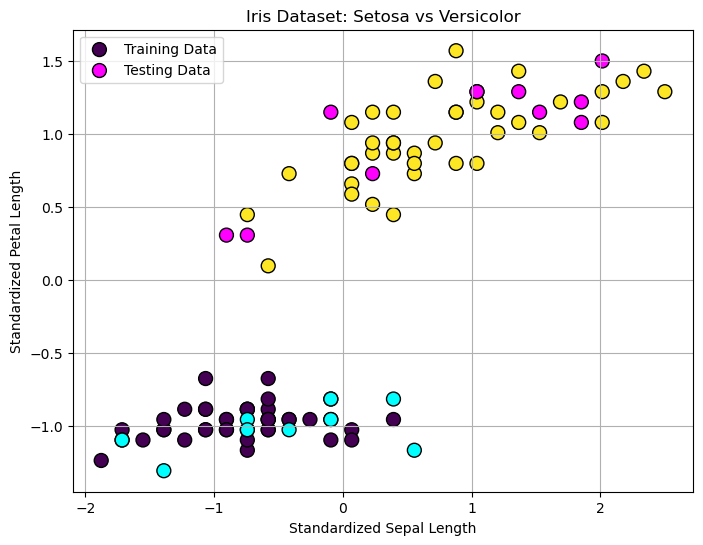

In [131]:

# 1. Load the Iris dataset
iris = load_iris()
X = iris.data  # Features
y = iris.target  # Labels

# 2. Select only two classes: Setosa (0) and Versicolor (1)
# Filter out Virginica (class 2)
mask = y < 2  # Keep only classes 0 and 1
X = X[mask]
y = y[mask]

# 3. Select two features: Sepal Length (column 0) and Petal Length (column 2)
X = X[:, [0, 2]]

# 4. Split into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# 5. Standardize the features
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# Display the shapes of the data and a few rows
print("Training features shape:", X_train.shape)
print("Testing features shape:", X_test.shape)
print("First 5 rows of training features:\n", X_train[:5])
print("First 5 training labels:\n", y_train[:5])

# Visualization of the dataset
plt.figure(figsize=(8, 6))
plt.scatter(X_train[:, 0], X_train[:, 1], c=y_train, cmap='viridis', edgecolor='k', s=100, label="Training Data")
plt.scatter(X_test[:, 0], X_test[:, 1], c=y_test, cmap='cool', edgecolor='k', s=100, label="Testing Data")
plt.title("Iris Dataset: Setosa vs Versicolor")
plt.xlabel("Standardized Sepal Length")
plt.ylabel("Standardized Petal Length")
plt.legend()
plt.grid(True)
plt.show()

Define Function to Plot Decision Boundary

In [155]:
def plot_decision_boundary(model, X, y, alpha):
    # Define the grid range
    x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
    y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1
    xx, yy = np.meshgrid(np.linspace(x_min, x_max, 100),
                         np.linspace(y_min, y_max, 100))
    
    # Predict over the grid
    grid = np.c_[xx.ravel(), yy.ravel()]
    Z = model.predict(grid).reshape(xx.shape)

    # Create a figure
    fig, ax = plt.subplots(figsize=(6, 5))

    # Plot the decision boundary
    contour = ax.contourf(xx, yy, Z, alpha=0.3, levels=[-0.1, 0.1, 1.1], colors=['blue', 'red'])

    # Scatter plot of the data points
    scatter = ax.scatter(X[:, 0], X[:, 1], c=y, cmap='bwr', edgecolor='k', s=50)

    # Title and labels
    ax.set_title(f'MLP Decision Boundary (alpha={alpha})')
    ax.set_xlabel('Sepal Length (standardized)')
    ax.set_ylabel('Petal Length (standardized)')

    # Remove axes for clarity
    ax.set_xticks([])
    ax.set_yticks([])

    # Tight layout
    plt.tight_layout()

    # Save the plot to a BytesIO object
    buf = BytesIO()
    plt.savefig(buf, format='png')
    plt.close(fig)
    buf.seek(0)
    return Image.open(buf)

Train MLP with Varying Alpha Values and Collect Images

In [159]:
def plot_decision_boundary(model, X, y, alpha):
    # Define the grid range
    x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
    y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1
    xx, yy = np.meshgrid(np.linspace(x_min, x_max, 100),
                         np.linspace(y_min, y_max, 100))
    
    # Predict over the grid
    grid = np.c_[xx.ravel(), yy.ravel()]
    Z = model.predict(grid).reshape(xx.shape)

    # Create a figure
    fig, ax = plt.subplots(figsize=(6, 5))

    # Plot the decision boundary
    ax.contourf(xx, yy, Z, alpha=0.3, levels=[-0.1, 0.1, 1.1], colors=['blue', 'red'])

    # Scatter plot of the data points
    ax.scatter(X[:, 0], X[:, 1], c=y, cmap='bwr', edgecolor='k', s=50)

    # Title and labels
    ax.set_title(f'MLP Decision Boundary (alpha={alpha})')
    ax.set_xlabel('Sepal Length (standardized)')
    ax.set_ylabel('Petal Length (standardized)')

    # Remove axes for clarity
    ax.set_xticks([])
    ax.set_yticks([])

    # Tight layout
    plt.tight_layout()

    # Save the plot to a BytesIO object
    buf = BytesIO()
    plt.savefig(buf, format='png')
    plt.close(fig)
    buf.seek(0)
    return Image.open(buf)

## RUN

Processing alpha=0.0010 (1/20)
Processing alpha=0.0021 (2/20)
Processing alpha=0.0043 (3/20)
Processing alpha=0.0089 (4/20)
Processing alpha=0.0183 (5/20)
Processing alpha=0.0379 (6/20)
Processing alpha=0.0785 (7/20)
Processing alpha=0.1624 (8/20)
Processing alpha=0.3360 (9/20)
Processing alpha=0.6952 (10/20)
Processing alpha=1.4384 (11/20)
Processing alpha=2.9764 (12/20)
Processing alpha=6.1585 (13/20)
Processing alpha=12.7427 (14/20)
Processing alpha=26.3665 (15/20)
Processing alpha=54.5559 (16/20)
Processing alpha=112.8838 (17/20)
Processing alpha=233.5721 (18/20)
Processing alpha=483.2930 (19/20)
Processing alpha=1000.0000 (20/20)
GIF saved as 'mlp_classification_boundaries.gif'


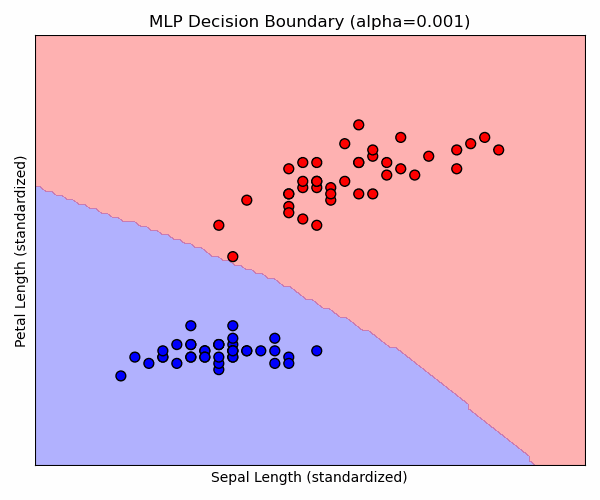

In [160]:
# Generate alpha values using np.logspace
alpha_values = np.logspace(-3, 3, 20)  # Generates 20 values from 10^-3 to 10^3

# Define the number of neurons in the hidden layer
n_neurons = 50

# Create the decision boundary GIF
gif_dir = create_decision_boundary_gif(alpha_values, X_train, y_train, n_neurons)

# Display the GIF
from IPython.display import Image as IPImage, display

# Display the generated GIF
display(IPImage(gif_dir))

Your gif should look like this:

<div style="text-align: center;">

### **Multilayer Perceptron Classification Boundaries**

![Classification Boundaries](mlp_classification_boundaries_example.gif)

*Figure 1: Demonstration of classification boundaries created by a Multilayer Perceptron (MLP) model.*

</div>

